In [22]:
import pandas as pd
import numpy as np
from utils.statistics import *

csv_path = 'C:\\Users\\Roman Bolzern\\Desktop\\D4\\train.csv'
train = pd.read_csv(csv_path, sep=";", parse_dates=["start","end","peak"], index_col="id")

### Class counts
Examine the imbalance of flare strengths.

*flux_to_class* maps the peak_flux of a flare to one of the following descriptors:
**free** = 1e-9, **B** >= 1e-7, **C** >= 1e-6, **M** >= 1e-5, and **X** >= 1e-4

The "unique ARs" describes from how many different active region numbers (noaa_num) the flares come from.

In [23]:
noaa_nums = np.unique(train["noaa_num"])
classes_samples = [flux_to_class(pf, only_main=True) for pf in train["peak_flux"]]
max_classes_ARs = [flux_to_class(max(train[train["noaa_num"] == noaa_num]["peak_flux"]), only_main=True) for noaa_num in noaa_nums]
classes, counts_samples = np.unique(classes_samples, return_counts=True)
classes, counts_ARs = np.unique(max_classes_ARs, return_counts=True)
pd.DataFrame(data={"samples":counts_samples, "unique ARs":counts_ARs}, index=classes)

,samples,unique ARs
B,2173,117
C,4783,413
M,574,97
X,30,14
free,3586,450


### Divergence HEK vs GOES peak flux
Difference of manual labels by experts (HEK) with the recorded flux on the sun (GOES) on a **log** scale

MSE: 0.003378930704985417
L1:  0.047873041593393416
Max: 0.07058107428570803


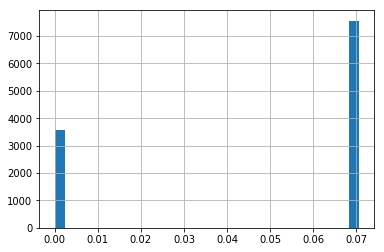

In [32]:
train['flux_from_hek'] = [class_to_flux(t) for t in train['type']]
logdiff = np.log10(train['flux_from_hek']) - np.log10(train['peak_flux'])
mse = (logdiff ** 2).mean()
l1 = abs(logdiff).mean()
print(f'MSE: {mse}')
print(f'L1:  {l1}')
print(f'Max: {max(abs(logdiff))}')
abs(logdiff).hist(bins=30)